In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [2]:
import geomloss
import matplotlib.pyplot as plt
import numpy as np
import ot
import pandas as pd
import scipy.stats as st
import seaborn
import torch
import tqdm

from utils.fix_for_geomloss import sinkhorn_loop

geomloss.sinkhorn_samples.sinkhorn_loop = sinkhorn_loop
# This is to fix the missing gradient for weights

$X \sim \sum_i w_i, \delta_{X_i}$ where the $X_i$'s are i.i.d. $U([-2, 2])$ and $w_i \propto f(X_i)$ where $f$ is the pdf of a normal distribution $ \mathcal{N}(0, \theta ^ 2)$ where $\theta \in \mathbb{R}^+$

In [3]:
_ = torch.random.manual_seed(31415926)

In [4]:
def transport_from_potentials(x, f, g, eps, w, N):
    C = (x.T - x) ** 2 / 2.
    FG = f.T + g
    T = torch.exp((FG - C)/eps**2) * w.unsqueeze(1)
    return T.T @ x, torch.full_like(f, 1/N).squeeze()

In [47]:
# def get_mean_and_grad(N, loc_val, times=10, seed = 27182):
#     _ = torch.random.manual_seed(seed)
#     res = []

#     loc = torch.tensor(loc_val, requires_grad=True)
#     scale = 1.
#     norm_dist = torch.distributions.Normal(loc, scale)
    
#     for _ in range(times):
#         X = torch.rand(N, requires_grad=True) * 4 - 2.


#         weights = norm_dist.log_prob(X)
#         max_weight = weights.max()
#         stable_weights = (weights - max_weight).exp()
#         scaled_weights = stable_weights / stable_weights.sum()
#         uniform_weights = torch.full_like(scaled_weights, 1/N, requires_grad=True)

#         epsilon = 0.01
#         biasedSampleLoss = geomloss.SamplesLoss(reach=None, potentials=True, debias=False, scaling=0.9, blur=epsilon)
#         alpha, beta = biasedSampleLoss(uniform_weights, X.unsqueeze(1), scaled_weights, X.unsqueeze(1))
#         X_tilde, w_tilde = transport_from_potentials(X.unsqueeze(1), alpha, beta, epsilon, scaled_weights, N)
#         res.append((X_tilde.mean(), torch.autograd.grad(X_tilde.mean(), [loc])[0], np.average(X.detach().numpy(), weights=scaled_weights.detach().numpy())))
        
#     return res

def get_grad(N, loc_val, scale_val, seed = 27182):
    _ = torch.random.manual_seed(seed)
    res = []

    loc = torch.tensor(loc_val, requires_grad=True)
    scale = scale_val
    norm_dist = torch.distributions.Normal(loc, scale)

    X = torch.rand(N, requires_grad=True) * 4 - 2.
    weights = norm_dist.log_prob(X)
    max_weight = weights.max()
    stable_weights = (weights - max_weight).exp()
    scaled_weights = stable_weights / stable_weights.sum()
    uniform_weights = torch.full_like(scaled_weights, 1/N, requires_grad=True)

    epsilon = 0.01
    biasedSampleLoss = geomloss.SamplesLoss(reach=None, potentials=True, debias=False, scaling=0.9, blur=epsilon)
    alpha, beta = biasedSampleLoss(uniform_weights, X.unsqueeze(1), scaled_weights, X.unsqueeze(1))
    X_tilde, w_tilde = transport_from_potentials(X.unsqueeze(1), alpha, beta, epsilon, scaled_weights, N)
        
    return torch.autograd.grad(X_tilde.mean(), [loc])[0].detach().numpy().sum()

In [48]:
random_int = np.random.randint(1, 1e6, )


In [9]:
torch.Tensor

Init signature: torch.Tensor(self, /, *args, **kwargs)
Docstring:      <no docstring>
File:           c:\programdata\anaconda3\lib\site-packages\torch\__init__.py
Type:           type
Subclasses:     Parameter


In [90]:
finite_diff = []
auto_diff = []

seed = random_int 
grad = get_grad(200, 0., 0.2, seed)


In [83]:
def compute_grad_numerically(loc, scale):
    linspace = np.linspace(-2, 2, 100)
    weights = st.norm.pdf(linspace, loc, scale)
    tab = linspace * (linspace - loc) / (scale ** 2) * weights
    return np.mean(tab)
    

In [112]:
def compute_grad_diff(loc, scale, eps=1e-4):
    linspace = np.random.uniform(-2, 2, 10000)
    weights1 = st.norm.pdf(linspace, loc, scale)
    avg_1 = np.average(linspace, weights=weights1)
    weights2 = st.norm.pdf(linspace, loc + eps, scale)
    avg_2 = np.average(linspace, weights=weights2)
    return (avg_2 - avg_1) / eps
    

In [113]:
locs = [-0.5, -0.25, 0., 0.25, 0.5]
scales = [0.25, 0.5, 1., 1.5, 2.]

In [114]:
theoretical_gradients = [ [ compute_grad_numerically(loc, scale) for loc in locs ] for scale in scales ]
autodiff_gradients = [ [ get_grad(500, loc, scale ) for loc in locs ] for scale in scales ]
difference_gradients = [ [ compute_grad_diff(loc, scale) for loc in locs ] for scale in scales ]


In [115]:
np.array(theoretical_gradients)

array([[0.24749999, 0.2475    , 0.2475    , 0.2475    , 0.24749999],
       [0.24329162, 0.24668183, 0.24726015, 0.24668183, 0.24329162],
       [0.15901249, 0.17835222, 0.18493272, 0.17835222, 0.15901249],
       [0.08554178, 0.0933635 , 0.09604907, 0.0933635 , 0.08554178],
       [0.04666373, 0.04945435, 0.05040407, 0.04945435, 0.04666373]])

In [116]:
np.array(difference_gradients)

array([[1.01604342, 1.00435115, 1.03216065, 0.99592444, 0.99907274],
       [0.98799672, 0.98150207, 1.00129879, 0.98639051, 0.99169505],
       [0.72376156, 0.760581  , 0.78562283, 0.76529858, 0.72282705],
       [0.4600503 , 0.45548071, 0.46843671, 0.46043591, 0.45868325],
       [0.2919079 , 0.28995706, 0.28853433, 0.2875588 , 0.29051462]])

In [100]:
autodiff_gradients = pd.DataFrame(np.array(autodiff_gradients), columns = locs, index = scales )
theoretical_gradients = pd.DataFrame(np.array(theoretical_gradients), columns = locs, index = scales )

In [101]:
print(autodiff_gradients.to_latex())
print()
print(theoretical_gradients.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &     -0.50 &     -0.25 &      0.00 &      0.25 &      0.50 \\
\midrule
0.25 &  0.053832 &  0.116715 &  0.145680 &  0.124257 &  0.039876 \\
0.50 &  0.143278 &  0.228782 &  0.259055 &  0.245363 &  0.164323 \\
1.00 &  0.116835 &  0.169257 &  0.189752 &  0.167950 &  0.114907 \\
1.50 &  0.049181 &  0.050599 &  0.051048 &  0.049108 &  0.046073 \\
2.00 &  0.017662 &  0.017207 &  0.016862 &  0.016544 &  0.016984 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrrrrr}
\toprule
{} &     -0.50 &     -0.25 &      0.00 &      0.25 &      0.50 \\
\midrule
0.25 &  0.247500 &  0.247500 &  0.247500 &  0.247500 &  0.247500 \\
0.50 &  0.243292 &  0.246682 &  0.247260 &  0.246682 &  0.243292 \\
1.00 &  0.159012 &  0.178352 &  0.184933 &  0.178352 &  0.159012 \\
1.50 &  0.085542 &  0.093363 &  0.096049 &  0.093363 &  0.085542 \\
2.00 &  0.046664 &  0.049454 &  0.050404 &  0.049454 &  0.046664 \\
\bottomrule
\end{tabular}



In [89]:
grads_plus.mean()

AttributeError: 'tuple' object has no attribute 'mean'

In [40]:
grads = np.array([ k.detach().numpy().sum() for k in grads ])

(array([ 1.,  1., 75., 17.,  0.,  2.,  2.,  0.,  0.,  2.]),
 array([-3.3661075 , -2.504196  , -1.6422846 , -0.78037316,  0.0815383 ,
         0.94344974,  1.8053612 ,  2.6672726 ,  3.529184  ,  4.3910956 ,
         5.253007  ], dtype=float32),
 <a list of 10 Patch objects>)

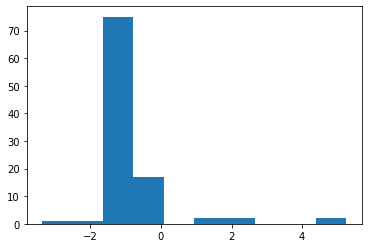

In [31]:
plt.hist(diff_grad / grads - 1)

In [87]:
diff_grad

NameError: name 'diff_grad' is not defined

In [33]:
grads

array([-0.04227133,  0.04091082, -0.00978464, -0.09499675,  0.03833718,
       -0.02371318, -0.00136001, -0.03693785, -0.12171192, -0.00899773,
        0.08610975,  0.03607482,  0.07692624, -0.12898453, -0.04471462,
       -0.02538247, -0.07557618, -0.00187918, -0.04974646, -0.06259524,
       -0.00230798,  0.06862214, -0.02503491, -0.0661673 , -0.03061059,
       -0.05011686,  0.05488196,  0.03896873,  0.0900353 ,  0.00844844,
        0.01810246, -0.02338212, -0.02952169,  0.1095877 ,  0.00367017,
        0.12743108,  0.04299772, -0.07400817, -0.05347732, -0.07454488,
        0.01672689,  0.03989759,  0.00230828,  0.01066031,  0.04254557,
       -0.02128766, -0.03349001, -0.07224014,  0.03659174,  0.02908496,
        0.05064617,  0.01330398,  0.00302699,  0.00479886, -0.0773503 ,
       -0.00085711,  0.0578791 , -0.01675381,  0.06852276, -0.03650057,
       -0.07032397,  0.03814838,  0.0409254 , -0.07700247, -0.07394167,
       -0.04611317,  0.21193849, -0.00216643, -0.03921271, -0.04